# COVID-19 CT Images Segmentation
La solución está basada en el siguiente notebook: https://www.kaggle.com/code/maedemaftouni/pytorch-baseline-for-semantic-segmentation/notebook.

**Integrantes:**
* Andrea Medina Rico | A01705541
* Diego Lira García | A01710369
* Ernesto Acosta Ruiz | A01364982
* Gabriela Chimali Nava Ramírez | A01710530
* Victor Adid Salgado Santana | A01710023

## Introducción
La pandemia por COVID-19 fue uno de los mayores retos de salud de este siglo. Las imágenes de tomografías computarizadas (CT) se convirtieron en un recurso clave para identificar patrones en los pulmones asociados a la presencia del virus. Sin embargo, analizar manualmente estas imágenes requiere especialistas, convirtiéndolo en un proceso lento y sujeto a la variabilidad de quienes lo analicen.

En este contexto, la segmentación de imágenes surge como una técnica fundamental para realizar diagnósticos. Su objetivo es etiquetar cada pixel de la imagen, diferenciando estructuras o regiones de interés. En el caso de COVID-19, permite resaltar de manera automática las zonas de infección en los pulmones, apoyando la detección temprana, evaluación de la extensión de la afectación por la enfermedad y el seguimiento de la evolución clínica.

El presente proyecto se centra en el desarrollo y aplicación de modelos de segmentación basados en deep learning para imágenes de tomografía computarizada de pacientes con COVID-19. Se busca explorar el potencial de la inteligencia artificial como complemento en el diagnóstico médico, ofreciendo resultados más rápidos y consistentes que el análisis tradicional.

En el proceso, se tuvo en mente el seguimimiento de principios éticos generales. Las imágenes utiilizadas provienen de dos librerías públicas, radiopedia y medseg. Ambas aportan datos anónimos, sin datos personales ni identiificadores, cumpliendo con principios básicos de protección de datos. Se aclara que el modelo generado, como se especificó anteriormente, es propuesto como un complemento en el diagnóstico médico y no busca reemplazar la aprobación médica. 

## Configuración inicial

In [1]:
!pip install -r /work/requirements.txt --quiet

      copying pandas/io/formats/csvs.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/excel.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/format.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/html.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/info.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/latex.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/printing.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/string.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      copying pandas/io/formats/style.py -> build/lib.linux-x86_64-cpython-311/pandas/io/formats
      creating build/lib.linux-x86_64-cpython-311/pandas/io/json
      copying pandas/io/json/__init__.py -> build/lib.linux-

In [2]:
# Re-import the modules after installation
import matplotlib.colors as mcolors
import tensorflow
import albumentations
import cv2

2025-09-18 08:26:54.532063: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 08:26:54.549394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758198414.570051    1059 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758198414.576351    1059 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758198414.592504    1059 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import os
import kagglehub
os.environ["KAGGLE_USERNAME"] = "adidsalgado"
os.environ["KAGGLE_KEY"] = "81ea84d803d941d9c6315c66b885e1a6"

In [4]:
covid_segmentation_path = kagglehub.competition_download('covid-segmentation')

print('Data source import complete.')

Data source import complete.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Ensure compatibility by upgrading numpy to the latest version

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
prefix = covid_segmentation_path

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

## Análisis de los datos

### Análisis exploratorio de los datos (EDA)
Las imágenes utilizadas dentro de la competencia provienen de dos datasets:
* **Medseg:**
    Dataset pequeño y previamente procesado que contiene 100 cortes axiales de más de 40 pacientes diagnosticados con COVID-19. Cada imagen tiene un tamaño de 512 * 512.
    * *images_medseg*: 100 cortes para entrenamiento.
    * *masks_medseg*: 100 máscaras para entrenamiento con cuatro canales:
        0 - *ground glass:* opacidades en vidrio esmerilado, típicos en COVID-19.
        1 - *consolidations:* consolidaciones, es decir, zonas más blancas y densas.
        2 - *lungs other:* otras partes del pulmón, aunque no significa que sea saludable.
        3 - *background:* todo aquello fuera del pulmón.
    * *test_images_medseg*: 10 cortes destinados para pruebas.

* **Radiopedia:**
    Dataset proveniente de 9 volúmenes de CT. Contiene 829 cortes, de los cuales 373 fueron declarados positivos tras la evaluación de un radiólogo. Igualmente, las imágenes tienen tamaño de 512 * 512.
    * *images_radiopedia:* 829 cortes para entrenamiento.
    * *masks_radiopedia:* 829 máscaras para entrenamiento, con los mismos cuatro canales explicados previamente.

In [7]:
print("Imágenes radiopedia: ",images_radiopedia.shape)
print("Máscaras radiopedia: ",masks_radiopedia.shape)
print("Imágenes medseg: ",images_medseg.shape)
print("Máscaras medseg: ",masks_medseg.shape)
print("Imágenes testeo: ",test_images_medseg.shape)

Imágenes radiopedia:  (829, 512, 512, 1)
Máscaras radiopedia:  (829, 512, 512, 4)
Imágenes medseg:  (100, 512, 512, 1)
Máscaras medseg:  (100, 512, 512, 4)
Imágenes testeo:  (10, 512, 512, 1)


In [8]:
print("Ejemplo de máscara para un pixel: ")
print(masks_medseg[0][0][0])
print("Ejemplo de pixel de una imagen:")
print(images_medseg[0][0][0])

Ejemplo de máscara para un pixel: 
[0 0 0 1]
Ejemplo de pixel de una imagen:
[-1408.5106]


In [9]:
cmap2 = mcolors.ListedColormap([
    (240/255, 45/255, 58/255),    # Clase 0 = Imperial Red
    (240/255, 239/255, 244/255),   # Clase 3 = Ghost White
    (255/255, 210/255, 63/255),   # Clase 2 = Sunglow
    (16/255, 25/255, 53/255)     # Clase 1 = Oxford Blue
])

def visualize(
    image_batch, 
    mask_batch=None, 
    pred_batch=None, 
    num_samples=8, 
    hot_encode=True,
    cmap=None):

    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(
                        num_classes + 1, 
                        num_samples, 
                        figsize=(num_samples * 2, 
                        (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode: 
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else: 
            ax_image.imshow(image_batch[i,:,:], cmap=cmap)
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

En las siguientes visualizaciones, se observa la imagen original de los pulmones en la primer fila. Las siguientes cuatro filas pertenecen cada una a una de las máscaras explicadas anteriormente. 

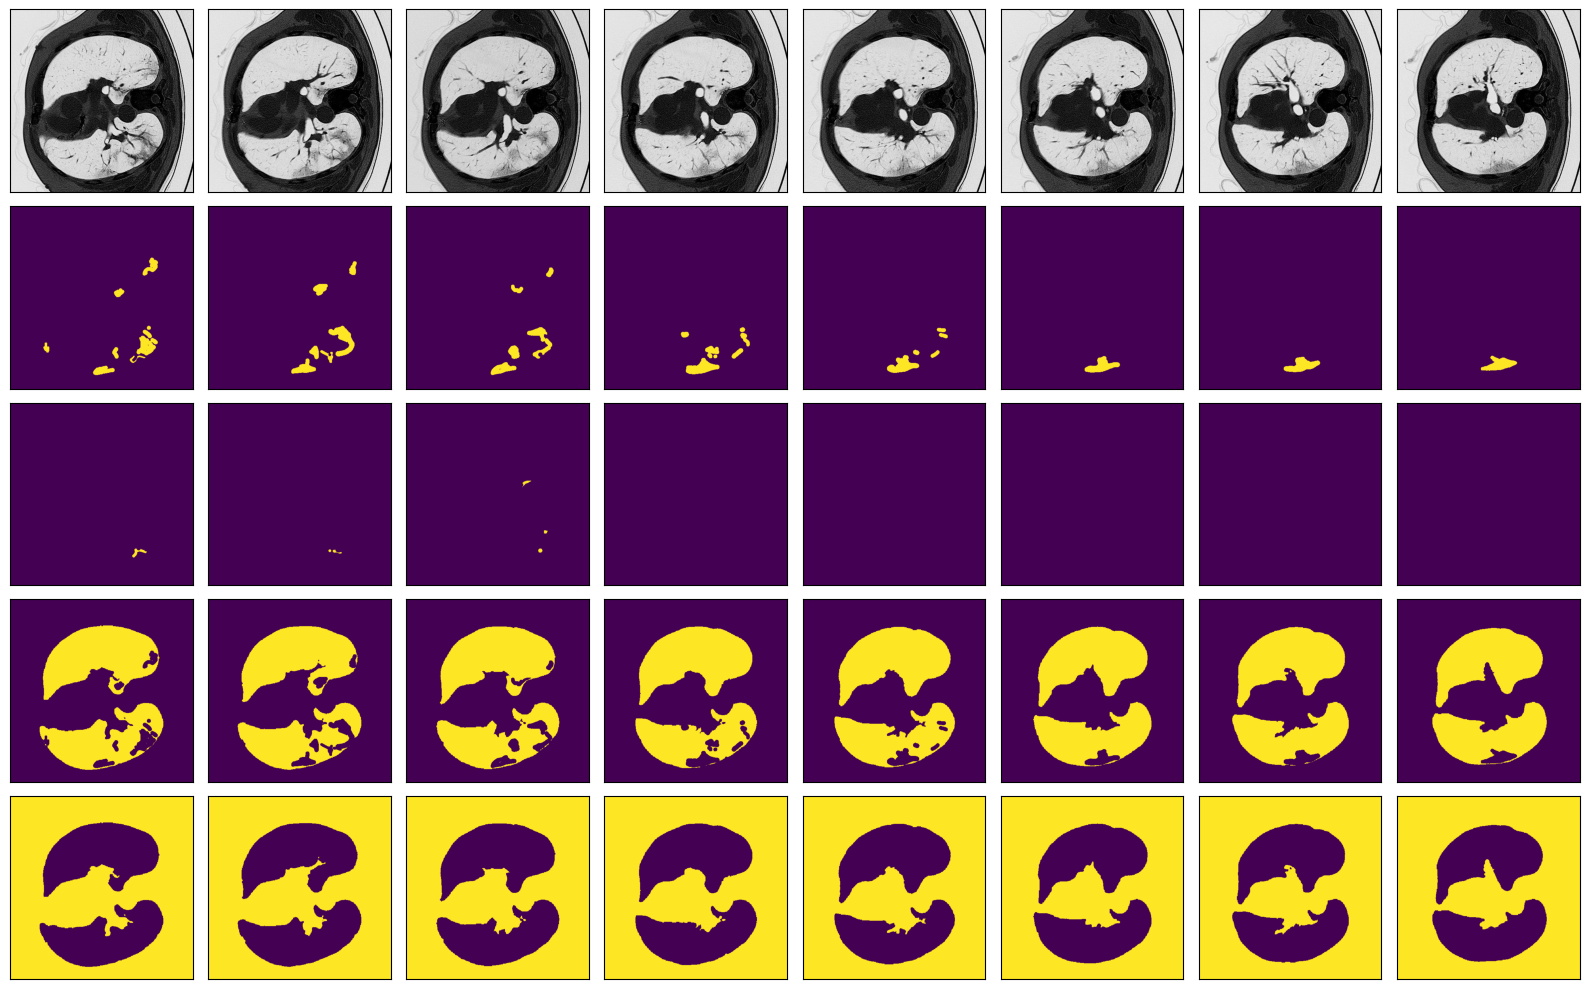

In [10]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

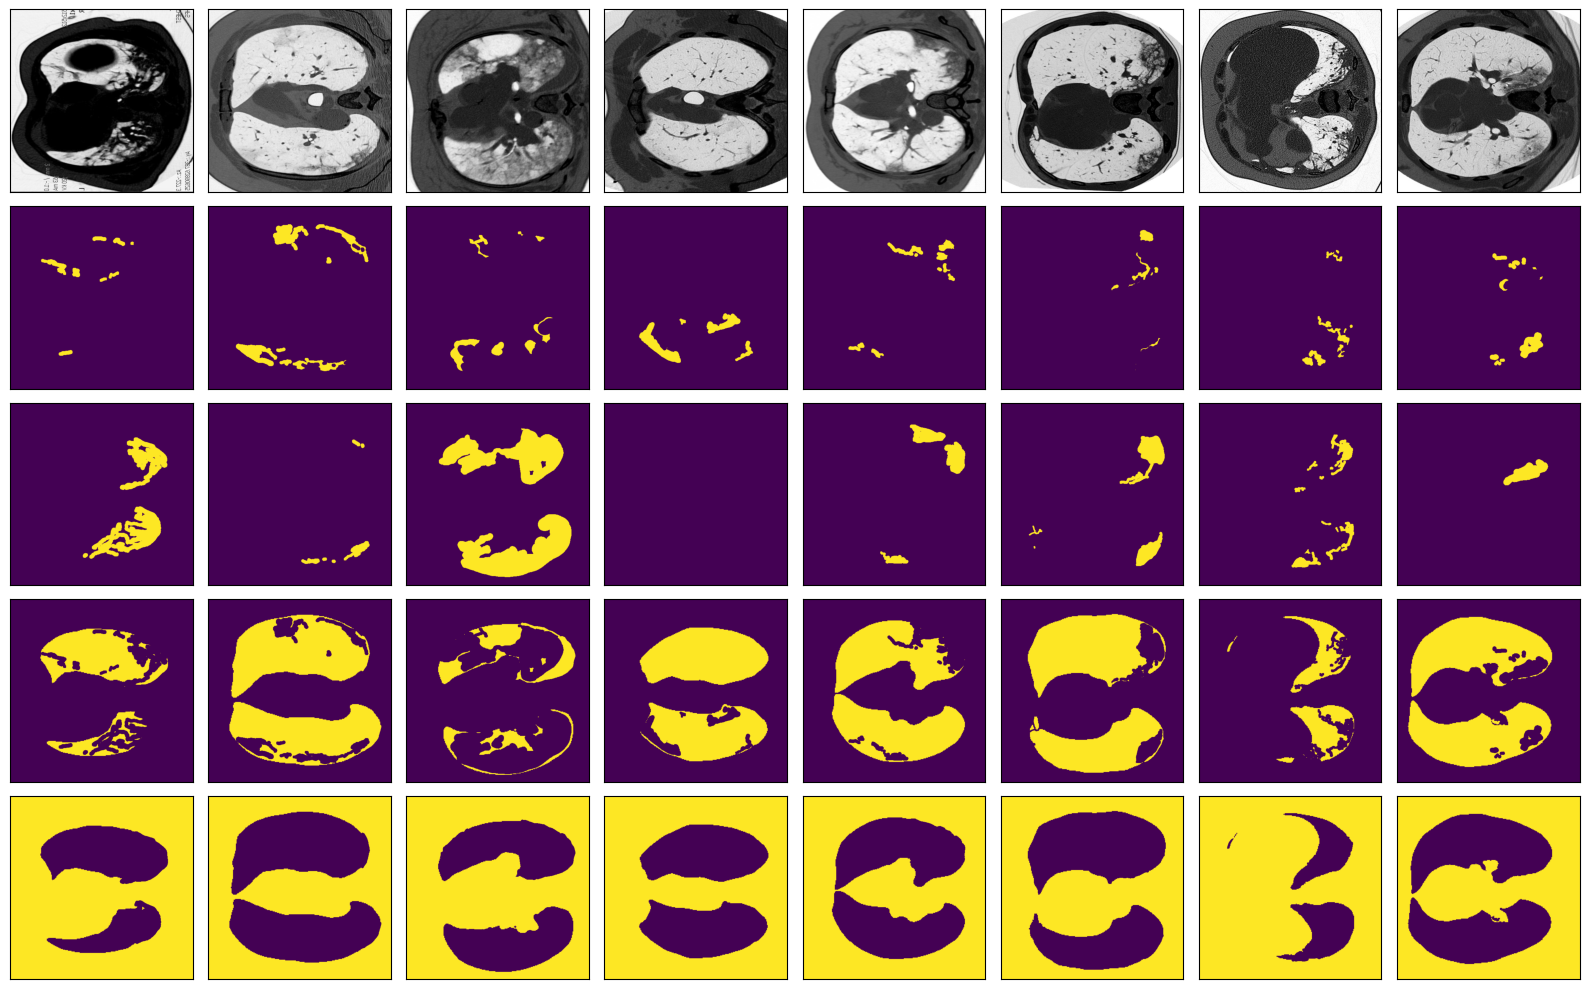

In [11]:
visualize(images_medseg[30:], masks_medseg[30:])

### Explicación de las métricas
* min: Pixel más oscuro.
* max: Pixel más brillante.
* mean: Media de todos los pixeles.
* median: Valor central al ordenar todos los pixeles.
* std: Variabilidad de los pixeles.

In [12]:
def statistic_metrics(images):
    print(f'min {images.min()}, max {images.max()}, mean {images.mean()}, median {np.median(images)} std {images.std()}')
print("Imágenes de radiopedia: ")
statistic_metrics(images_radiopedia)
print("Imágenes de medseg: ")
statistic_metrics(images_medseg)

Imágenes de radiopedia: 
min -1414.765380859375, max 291.040771484375, mean -450.6806640625, median -248.8426513671875 std 495.4974060058594
Imágenes de medseg: 
min -1606.521728515625, max 597.8046875, mean -443.2362976074219, median -217.85714721679688 std 494.8154296875


**Radiopaedia:**
1. min (-1414.76): Casi aire puro en escala Hounsfield (-1000 HU).
2. max (291.04): Típico de hueso blando o tejido más denso (>0 HU).
3. mean (-450.68): Corresponde a valores ernamos a tejido pulmonar/aire.
4. median (-248.84): La mitad de los pixeles se encuentran en la zona de pulmón/aire.
5. std (495.49): Alta variabilidad.

**MedSeg:**
1. min (-1606.52): Rango negativo más extremo que Radiopaedia, quizá por normalización.
2. max (597.80): Valores más altos, posiblemente tejidos más duros o artefactos del escaneo.
3. mean (-443.23): Alrededor de tejido pulmonar.
4. median (-217.85): En este dataset hay más proporción de tejido/lesión de aire puro.
5. std (494.81): Variabilidad similar/alta.

**Conclusiones:**
* Ambos datasets con distribuciones similares (promedio ≈ -440, desviación ≈ 495).
* Radiopaedia está más centrado en valores correspondientes a aire/pulmón sano.
* MedSeg tiene un rango más amplio, por mayor variedad de imágenes o diferentes configuraciones.

Se realizó un histograma para complementar este análisis. 

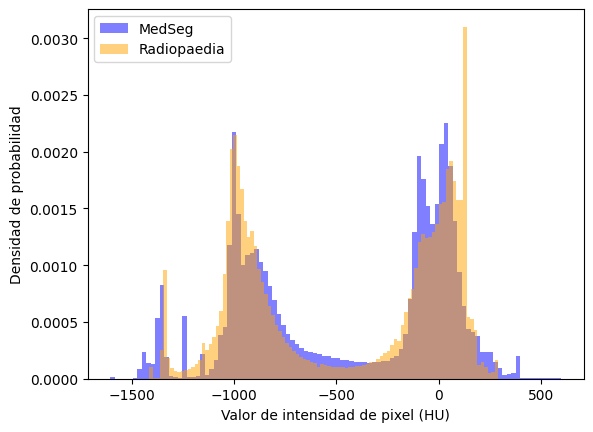

In [13]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), 
            bins=100, 
            density=True, 
            color='b', 
            alpha=1 if images2 is None else 0.5,
            label='MedSeg')
    if images2 is not None:
        plt.hist(images2.ravel(), 
            bins=100, 
            density=True, 
            alpha=0.5, 
            color='orange',
            label='Radiopaedia')
    plt.xlabel('Valor de intensidad de pixel (HU)')
    plt.ylabel('Densidad de probabilidad')
    plt.legend()
    plt.show();

plot_hists(images_medseg, images_radiopedia)

Con el histograma se observa la distribución de los valores (en HU) de las imágenes de radiopaedia y med_seg. Se observa un comportamiento similar a una distribución "bimodal", dónde los picos de las distribuciones se encuentran en los -1000 HU (aire) y los 0 HU (agua). Y MedSeg contiene casos más variados y extremos que puede ser bueno para entrenar modelos más robustos, pero hace más difícil el aprendizaje.

In [14]:
def visualize_HU(image):
    """
    Visualiza una sola imagen de CT en escala de HU con colores asignados a rangos de tejidos.
    
    Rango de HU usado:
        - Air: (-1200 a -950)  -> azul oscuro
        - Lungs: (-950 a -650) -> celeste
        - Fat: (-650 a -100)    -> amarillo
        - Water/Soft tissue: (-100 a 50) -> verde
        - Muscle: (50 a 300)   -> naranja
        - Bone : (300 a 800)         -> blanco
    """

    # Definir los límites y colores
    bounds = [-1200, -950, -650, -100, 50, 300, 800, 1200]
    colors = ['#F54927',
              '#001f3f', 
              '#0074D9', 
              '#FFDC00',
              '#2ECC40', 
              '#FF851B', 
              '#AAAAAA']
    
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N, clip=True)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(image.squeeze(), cmap=cmap, norm=norm)
    ax.axis("off")
    ax.set_title("CT Scan - Coloreada por rangos de HU")

    # Barra de colores
    cbar = plt.colorbar(
        mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        boundaries=bounds,
        ticks=bounds,
        ax=ax,
        shrink=0.7
    )
    cbar.ax.set_ylabel("Unidades Hounsfield (HU)", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

Esta imagen corresponde a un corte axial de tórax en tomografía computarizada, coloreado según rangos de Unidades Hounsfield (HU). El color rojo intenso representa el aire, tanto fuera del cuerpo como en las cavidades pulmonares, mientras que el azul oscuro corresponde al parénquima pulmonar aireado. Dentro de los pulmones se observan áreas en amarillo y verde, que indican zonas de mayor densidad y pueden corresponder a opacidades en vidrio esmerilado o consolidaciones típicas del COVID-19. El centro torácico, también aparece en tonalidades amarillas y verdes por tratarse de tejido blando y sangre. En conjunto, este mapa facilita diferenciar aire, tejidos blandos, hueso y posibles lesiones pulmonares con mayor claridad que una escala de grises tradicional.

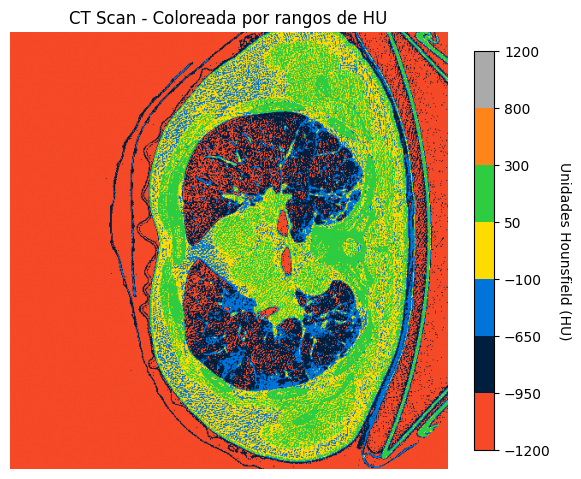

In [15]:
visualize_HU(images_medseg[50])

Gráfica para observar las tomografías con las secciones coloreadas por rango de valores HU:
* Aire: -1000 HU
* Pulmones: -950 a -650 HU
* Grasa subcutánea: -100 a -115 HU
* Agua: 0 HU (por definición)
* Músculo: 45 a 50 HU
* Hueso Trabecular / Tejido poroso: 300 - 800 HU
* Hueso (Cortical): >1000 HU

### Preprocesamiento de los datos

Las máscaras de segmentación se encuentran en *one-hot encoding*. Esto significa que cada píxel posee cuatro canales, uno por cada clase posible. Sólo un canal está activo a la vez, por lo que un píxel podría representarse como [0, 0, 1, 0], indicando que pertenece a la clase 2. Esto implica que cada clase se muestra como una imagen binaria independiente, como se observa en las visualizaciones anteriores donde cada fila pertenecía a un canal. 

Para facilitar la comprensión, se realiza una conversión a una representación compacta de los canales. En lugar de ser cuatro, cada píxel se reduce a un único valor entero que corresponde a su clase (0, 1, 2, 3). Con este cambio, la forma de la máscara pasa de (H, W, 4) a (H, W), donde cada píxel contiene directamente la etiqueta de su clase. Además, se asigna una paleta de colores para que cada clase reciba un color distinto, lo que permite visualizar toda la segmentación en una sola imagen en lugar de en cuatro capas separadas.

Converteed medseg masks shape: (100, 512, 512)
Converted radiopedia masks shape: (829, 512, 512)


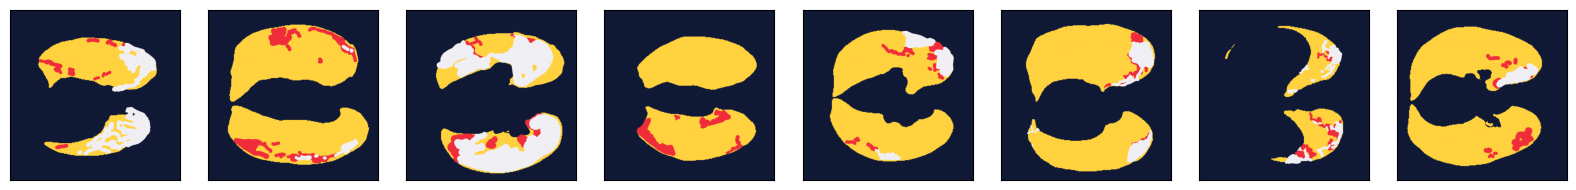

In [16]:
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

palette = [[0], [1], [2], [3]]

masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

print('Converteed medseg masks shape:',masks_medseg_recover.shape)
print("Converted radiopedia masks shape:", masks_radiopedia_recover.shape)

visualize(masks_medseg_recover[30:],hot_encode=False, cmap=cmap2)

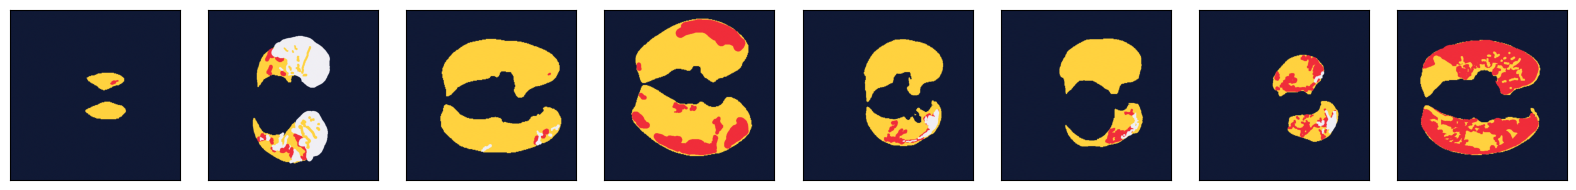

In [17]:
visualize(masks_medseg_recover[22:30],hot_encode=False, cmap=cmap2)

En el preprocesamiento de las imágenes, se realiza un recorte y normalización de sus valores. Los límites designados de HU son de -1200 a 400. Los valores menores a -1200 no son significativos, pues se trata de aire exterior. Por otro lado, mayores a 400 se refieren a estructuras más densas no relevantes para este escenario. Esto se hace porque pueden distorsionar la normalización.

Con ayuda de los percentiles, se seleccionó el 90% central de los datos para evitar datos anormales o ruido.

La normalización utilizada fue z-score, haciendo que la media sea de 0 y la desviación estándar de 1. Esto evita sesgos debido a valores demasiado grandes. Ahora, la siguiente gráfica muestra la densidad de probabilidad de los datos de los imágenes ya normalizados.

In [18]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 400] = 400
    images_arr[images_arr < -1200] = -1200
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


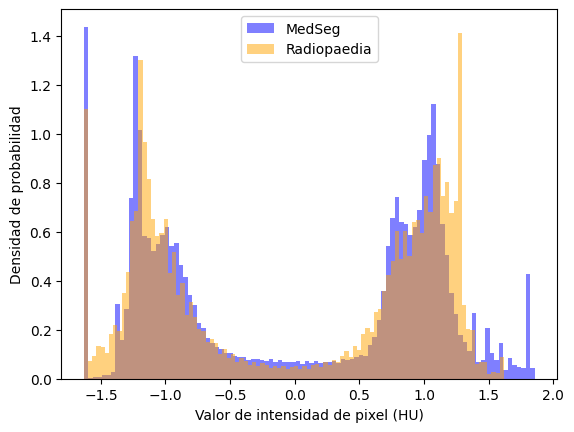

In [19]:
plot_hists(test_images_medseg, images_radiopedia)

### División de datos

Para evaluar el desempeño del modelo, se necesitarán tres conjuntos de datos:
* *train*: datos utilizados para entrenar el modelo.
    Se utilizan todas las imágenes y máscaras de Radiopedia, por su diversidad y mayor apego a la realidad. Y se le agregan a este conjunto las de MedSeg en un rango de la 24 a la 100 (76), quedando con 905 cortes.

* *validation*: datos utilizados para verificar el aprendizaje del modelo y ajustar hiperparámetros en caso de detectar un diagnóstico no esperado (underfitting/overfitting).
    Se utilizan las imágenes y máscaras de medseg, en un rango del 1 al 24.

* *test*: datos utilizados para probar el desempeño final del modelo.
    Se utiliza el conjunto de *test* con 10 imágenes, proporcionado por MedSeg.

In [20]:
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

# Procesará toda la validación, sin dividirla en mini-batches
batch_size = len(val_masks)

'''
# Liberar memoria eliminando variables que no se usarán más
-----> NOTA: Regresar al final
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg
'''

'\n# Liberar memoria eliminando variables que no se usarán más\n-----> NOTA: Regresar al final\ndel masks_medseg_recover\ndel masks_radiopedia_recover\ndel images_radiopedia\ndel masks_radiopedia\ndel images_medseg\ndel masks_medseg\n'

In [21]:
print("Train images: ", train_images.shape)
print("Train masks: ", train_masks.shape)
print("Val images: ", val_images.shape)
print("Val masks: ", val_masks.shape)
print("Batch size: ", batch_size) 

Train images:  (905, 512, 512, 1)
Train masks:  (905, 512, 512)
Val images:  (24, 512, 512, 1)
Val masks:  (24, 512, 512)
Batch size:  24


### Aumento de datos (augmentations):

El aumento de datos se utiliza con el objetivo de generar variaciones de las imágenes y añadirlas a los conjuntos de datos, debido a que una mayor cantidad de ejemplos ayuda al modelo a generalizar mejor (limitar overfitting). 
* Para *train*: se hacen rotaciones, para evitar dependencias con la rotación, recortes, para no necesitar de la imagen completa, y vueltas de las imágenes, para que no memorice direcciones. Los bordes que quedan vacíos se rellenan con los bordes de la imagen.
* Para *validation*: sólo se reduce el tamaño a 256 x 256, para tener variaciones sin modificar el contenido.

In [22]:
SOURCE_SIZE = 512
TARGET_SIZE = 256

train_augs = albumentations.Compose([
    # Invatiante a rotación
    albumentations.Rotate(limit=360, 
                          p=0.9, 
                          border_mode=cv2.BORDER_REPLICATE),
    # Simular imágenes on distintos encuadres
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   (TARGET_SIZE, 
                                   TARGET_SIZE), 
                                   interpolation=cv2.INTER_NEAREST),
    # Balancear simetría, debe detecctarse igual en pulmones tanto izq como der
    albumentations.HorizontalFlip(p=0.5),

])

# Sólo redimensiona a 256x256
val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

## **Carga y preparación de imágenes y máscaras**

1. Clase Dataset:
* Constructor "init":
    * Guardado de imágenes y máscaras, pueden pasarse transformaciones si aplican. Además se definien valores para normalizar (media y desviación estándar acorde con ImageNet respecto a imágenes en escala de grises (por eso sólo se usa un canal).

* "getitem":
    * Recupera imagen y másara, si hay augmentations se aplica a ambas. Se pasa la imagen a formato PIL para normalizar con ToTensor() y Normalize(). Para obtener un tensor entre -1 y 1.

* "len": La cantida de elementos, que luego usa PyTorch para saber hasta donde entrenar o evaluar.

* "tiles": Divide imágenes grandes en parches pequeños con unfold de PyTorch.

2. DataLoader se en carga de pasar los datos en batches al modelo.

In [23]:
from PIL import Image
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import time

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader  
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]

    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']
        
        if self.augmentations is None:
            image = Image.fromarray(image)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
    
        return image, mask
    
    def __len__(self):
        return len(self.images)
    
    def tiles(self, image, mask):

        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    
                
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)       

# Mezcla las imágenes
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# No mezcla para evaluar siempre sobre el mismo conjunto en orden
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

cuda


In [24]:
print("Train dataset: ", len(train_dataset))
img,mask = train_dataset[0]
print("Imágenes train dataset: ", img.shape)
print("Mask: train dataset", mask.shape)

print("Val dataset: ", len(val_dataset))
img,mask = val_dataset[0]
print("Imágenes train dataset: ", img.shape)
print("Mask: train dataset", mask.shape)


Train dataset:  905
Imágenes train dataset:  torch.Size([1, 256, 256])
Mask: train dataset torch.Size([256, 256])
Val dataset:  24
Imágenes train dataset:  torch.Size([1, 256, 256])
Mask: train dataset torch.Size([256, 256])


### One-hot encoding

En el conjunto de *train*, se aplica one-hot encoding para regresar la información de los canales a como estaba el dataset en un inicio. Nuevamente, se tiene cuatro canales, uno por cada clase posible. Solo un canal está activo a la vez, por lo que un píxel podría representarse como [0, 0, 1, 0], indicando que pertenece a la clase 2. Cada clase se visualiza como una imagen binaria independiente. Cada canal mantiene el tamaño y orientación de la imagen inicial.

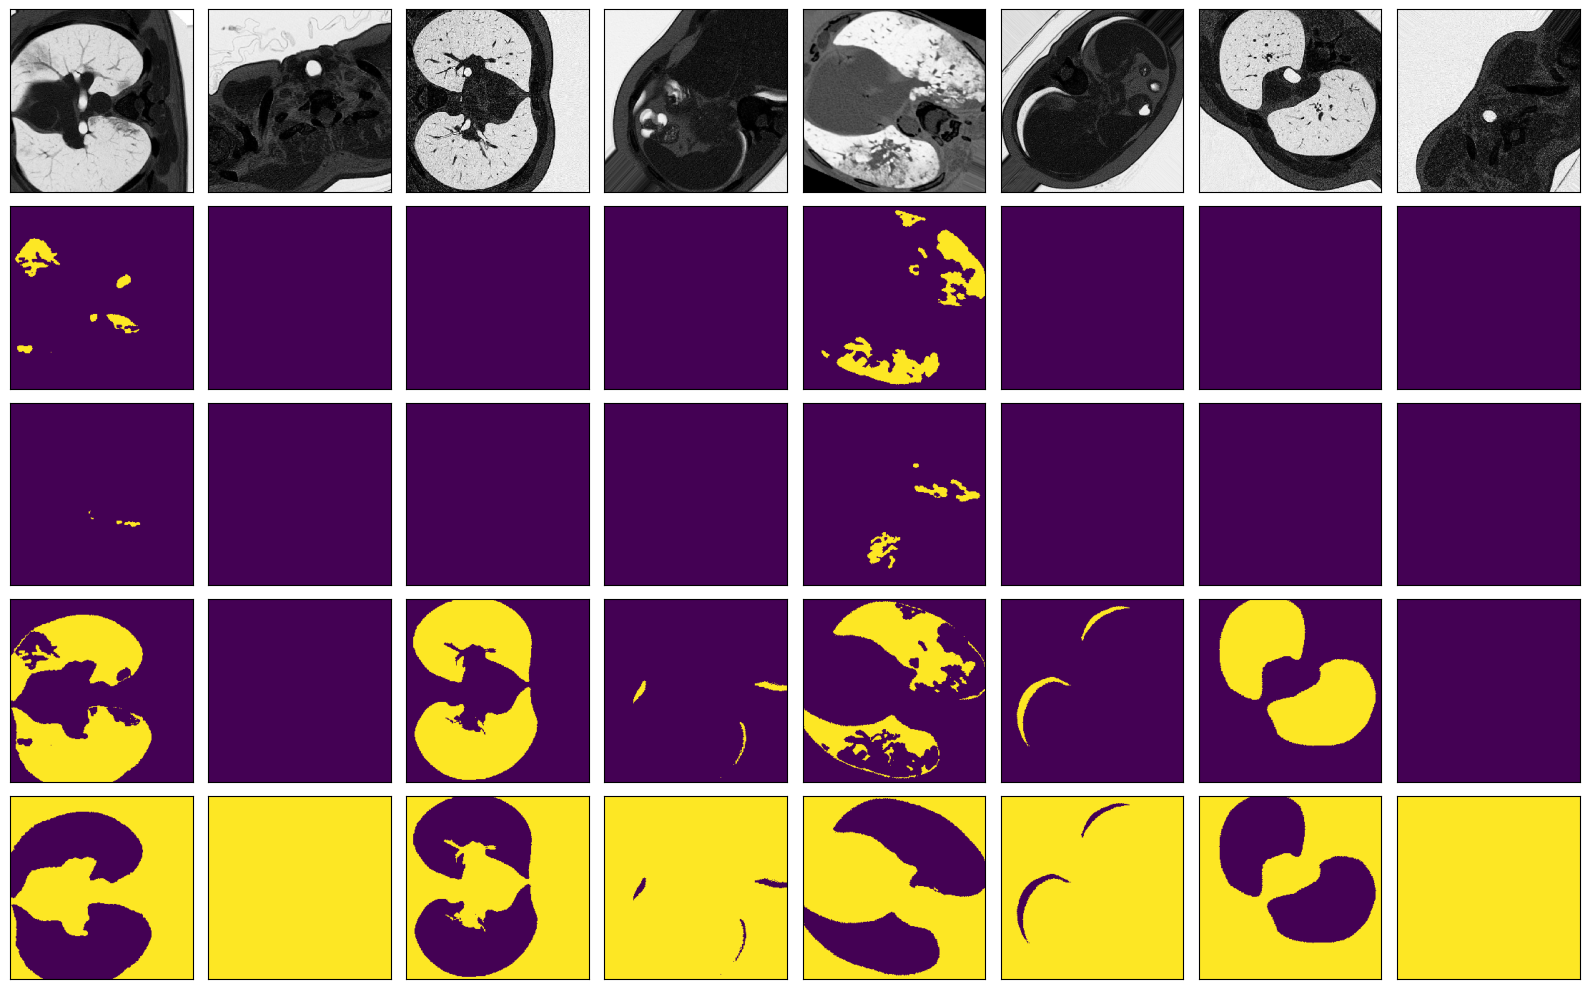

In [25]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        #print('colour',colour)
        equality = np.equal(mask, colour)
        #print('equality',equality)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

i,train_data = next(enumerate(train_dataloader))

mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1],-1).numpy(),palette)
#visualize(torch.unsqueeze(torch.squeeze(train_data[0],1),-1),mask_hot_encoded)
visualize(train_data[0].permute(0, 2, 3,1),mask_hot_encoded)


## Modelo UnetPlusPlus

### Métricas de evaluación

* **Pixel accuracy**: Métrica simple de proporción de pixeles predichos correctamente. Es una medida general, aunque tiende a porcentajes sesgados cuando la cantidad de pixeles entre clases no es la misma, pues esa proporción da una idea falsa de que el porcentaje predice adecuadamente.

In [26]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

* **Intersection over Union (IoU)**: Mide qué tanto se parece la predicción de segmentación a la máscara real en un rango de 0 a 1, siendo 0 nada en común y 1 una predicción perfecta.Como su nombre lo indica, divide la intersección sobre la unión, donde la intersección es la cantidad de pixeles con 1 tanto en la predicción como en el valor real. La unión es la cantidad de pixeles donde al menos uno tiene valor de 1, pueden ser ambos. 
    Se calcula uno por cada clase, por lo que, en este contexto, se tienen cuatro métricas de IoU. De esta manera, ayuda a identificar en qué clases se desempeña mejor o peor el modelo.

In [27]:
def iou(pred, gt):
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))
    u = float(np.sum(agg > 0))
    if u == 0:
        result = 1
    else:
        result = i/u
    return result

* **Mean Intersection over Union (mIoU)**: Funciona como métrica global del accuracy del modelo, debido a que promedia el IoU de todas las clases.

In [28]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

### Arquitectura del modelo

UNet++ es una variante de la arquitectura U-Net, diseñada para mejorar la segmentación semántica en imágenes médicas. A diferencia de U-Net, UNet++ utiliza **conexiones de salto anidadas** entre el encoder y el decoder, en vez de conexiones paralelas. Esto ayuda a reducir el "gap semántico" que ocurre en U-Net, donde se pueden perder detalles importantes al reconstruir la imagen segmentada.

En UNet++, durante la etapa de **encoding**, cada bloque toma únicamente la salida del encoder anterior. En la etapa de **decoding**, cada bloque recibe como entrada la salida del encoder y del decoder del mismo nivel, además de la salida del decoder del nivel inferior (a la cual se le aplica upscaling para igualar el tamaño de los canales). Esta estructura permite una mejor recuperación de detalles y mejora el accuracy en la segmentación.

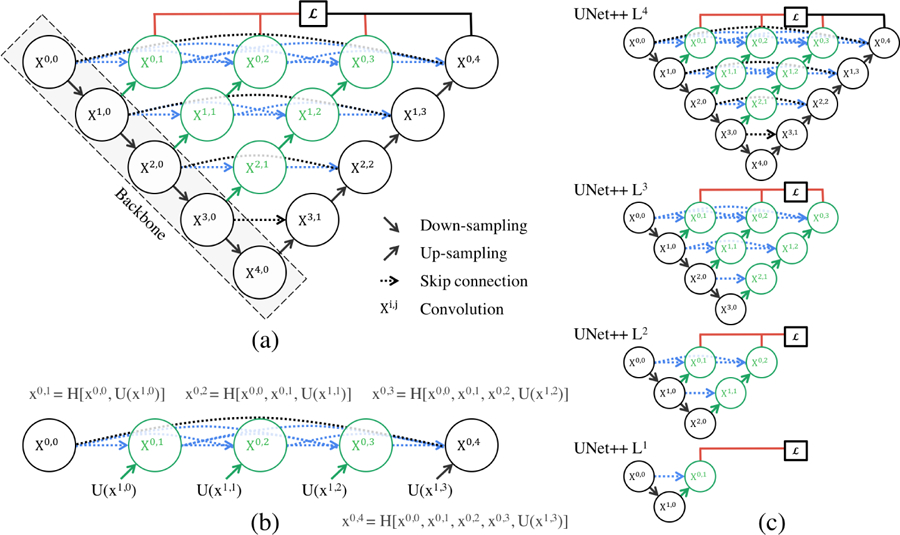

*Imagen de referencia de la arquitectura UNet++ obtenida de un artículo en la NCBI [5].*

**EfficientNet-B5** es una arquitectura de red neuronal convolucional optimizada para clasificación de imágenes, con 30M de parámeteros y requiere cerca de 9.9 GFLOPS por imágen de entreada. Destaca por su eficiencia y alto rendimiento, logrando mejores resultados con menos parámetros que modelos tradicionales. Se utiliza como encoder dentro de UNet++ para extraer características relevantes de las imágenes médicas.

In [29]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b5",
    encoder_weights='imagenet',
    encoder_depth=5,
    in_channels=1,
    classes=4,
    decoder_channels=[256, 128, 64, 32, 16]
)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

### Función de entrenamiento y validación

La función "fit" tiene como objetivo optimizar los parámetros del modelo y monitorear su desempeño cada época. Para:

* Entrenamiento:
Para cada batch del conjunto de train se realiza forward propagation, se calcula la pérdida y métricas de desempeño descritas anteriormente (Accuracy, mIoU) y se actualizan los pesos mediante backpropagation.

* Validación:
Al final de cada época, sobre el conjunto de validation se calcula la pérdida promedio y las métricas de desempeño.
    * Monitoreo de mejora: Si la pérdida disminuye se actualiza el valor mínimo y se guarda cada 5 mejoras. Si la pérdida no mejora en 7 épocas consecutivas imprime un mensaje de advertencia.
    * No implementamos Early Stopping (break) pues notabamos mejoras mínimas, pero significativas, incluso después de 7 épocas sin estas.
    * Finalmente se retorna un hostorial con las métricas por época para su posterior grafición y evaluaión del desempeño del modelo.

In [ ]:
# Función para devolver el learning rate actual del optimizador
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    #torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask =mask_tiles.to(device);
            #forward
            output = model(image)
            
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask =mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unetplusplus_efficientnet_b2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    #break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## Entrenamiento del modelo

In [31]:
max_lr = 1e-2
epoch = 50
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.768 
Epoch:1/50.. Train Loss: 0.860.. Val Loss: 0.768.. Train mIoU:0.372.. Val mIoU: 0.253.. Train Acc:0.706.. Val Acc:0.739.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.768 >> 0.431 
Epoch:2/50.. Train Loss: 0.197.. Val Loss: 0.431.. Train mIoU:0.541.. Val mIoU: 0.416.. Train Acc:0.973.. Val Acc:0.869.. Time: 0.66m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/50.. Train Loss: 0.083.. Val Loss: 0.497.. Train mIoU:0.604.. Val mIoU: 0.306.. Train Acc:0.979.. Val Acc:0.777.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/50.. Train Loss: 0.061.. Val Loss: 0.603.. Train mIoU:0.618.. Val mIoU: 0.312.. Train Acc:0.981.. Val Acc:0.773.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.603 >> 0.375 
Epoch:5/50.. Train Loss: 0.059.. Val Loss: 0.375.. Train mIoU:0.632.. Val mIoU: 0.413.. Train Acc:0.981.. Val Acc:0.845.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.375 >> 0.291 
saving model...
Epoch:6/50.. Train Loss: 0.055.. Val Loss: 0.291.. Train mIoU:0.677.. Val mIoU: 0.539.. Train Acc:0.981.. Val Acc:0.910.. Time: 0.71m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/50.. Train Loss: 0.057.. Val Loss: 0.459.. Train mIoU:0.709.. Val mIoU: 0.486.. Train Acc:0.981.. Val Acc:0.865.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.459 >> 0.207 
Epoch:8/50.. Train Loss: 0.047.. Val Loss: 0.207.. Train mIoU:0.728.. Val mIoU: 0.623.. Train Acc:0.983.. Val Acc:0.932.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:9/50.. Train Loss: 0.046.. Val Loss: 1.343.. Train mIoU:0.744.. Val mIoU: 0.285.. Train Acc:0.984.. Val Acc:0.752.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.343 >> 0.293 
Epoch:10/50.. Train Loss: 0.041.. Val Loss: 0.293.. Train mIoU:0.741.. Val mIoU: 0.542.. Train Acc:0.985.. Val Acc:0.925.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:11/50.. Train Loss: 0.065.. Val Loss: 13642008.000.. Train mIoU:0.719.. Val mIoU: 0.180.. Train Acc:0.978.. Val Acc:0.721.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 13642008.000 >> 314.714 
Epoch:12/50.. Train Loss: 0.079.. Val Loss: 314.714.. Train mIoU:0.612.. Val mIoU: 0.180.. Train Acc:0.973.. Val Acc:0.721.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 314.714 >> 2.064 
Epoch:13/50.. Train Loss: 0.056.. Val Loss: 2.064.. Train mIoU:0.656.. Val mIoU: 0.266.. Train Acc:0.979.. Val Acc:0.724.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.064 >> 1.117 
saving model...
Epoch:14/50.. Train Loss: 0.051.. Val Loss: 1.117.. Train mIoU:0.717.. Val mIoU: 0.362.. Train Acc:0.982.. Val Acc:0.797.. Time: 0.70m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:15/50.. Train Loss: 0.049.. Val Loss: 2.810.. Train mIoU:0.731.. Val mIoU: 0.196.. Train Acc:0.982.. Val Acc:0.724.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.810 >> 1.727 
Epoch:16/50.. Train Loss: 0.046.. Val Loss: 1.727.. Train mIoU:0.736.. Val mIoU: 0.444.. Train Acc:0.983.. Val Acc:0.802.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.727 >> 0.283 
Epoch:17/50.. Train Loss: 0.042.. Val Loss: 0.283.. Train mIoU:0.744.. Val mIoU: 0.535.. Train Acc:0.984.. Val Acc:0.917.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Epoch:18/50.. Train Loss: 0.040.. Val Loss: 0.301.. Train mIoU:0.757.. Val mIoU: 0.550.. Train Acc:0.985.. Val Acc:0.926.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:19/50.. Train Loss: 0.040.. Val Loss: 0.393.. Train mIoU:0.769.. Val mIoU: 0.523.. Train Acc:0.985.. Val Acc:0.880.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:20/50.. Train Loss: 0.047.. Val Loss: 0.539.. Train mIoU:0.747.. Val mIoU: 0.446.. Train Acc:0.983.. Val Acc:0.821.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.539 >> 0.225 
Epoch:21/50.. Train Loss: 0.040.. Val Loss: 0.225.. Train mIoU:0.756.. Val mIoU: 0.576.. Train Acc:0.985.. Val Acc:0.928.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:22/50.. Train Loss: 0.037.. Val Loss: 0.934.. Train mIoU:0.772.. Val mIoU: 0.428.. Train Acc:0.986.. Val Acc:0.831.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.934 >> 0.213 
Epoch:23/50.. Train Loss: 0.037.. Val Loss: 0.213.. Train mIoU:0.773.. Val mIoU: 0.607.. Train Acc:0.986.. Val Acc:0.935.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.213 >> 0.211 
saving model...
Epoch:24/50.. Train Loss: 0.038.. Val Loss: 0.211.. Train mIoU:0.771.. Val mIoU: 0.604.. Train Acc:0.986.. Val Acc:0.933.. Time: 0.70m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:25/50.. Train Loss: 0.038.. Val Loss: 0.357.. Train mIoU:0.760.. Val mIoU: 0.507.. Train Acc:0.986.. Val Acc:0.873.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.357 >> 0.192 
Epoch:26/50.. Train Loss: 0.034.. Val Loss: 0.192.. Train mIoU:0.782.. Val mIoU: 0.614.. Train Acc:0.987.. Val Acc:0.942.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.192 >> 0.174 
Epoch:27/50.. Train Loss: 0.034.. Val Loss: 0.174.. Train mIoU:0.785.. Val mIoU: 0.641.. Train Acc:0.987.. Val Acc:0.945.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:28/50.. Train Loss: 0.032.. Val Loss: 0.188.. Train mIoU:0.800.. Val mIoU: 0.638.. Train Acc:0.988.. Val Acc:0.946.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.188 >> 0.161 
Epoch:29/50.. Train Loss: 0.031.. Val Loss: 0.161.. Train mIoU:0.795.. Val mIoU: 0.650.. Train Acc:0.988.. Val Acc:0.948.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:30/50.. Train Loss: 0.033.. Val Loss: 0.174.. Train mIoU:0.786.. Val mIoU: 0.631.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.174 >> 0.160 
Epoch:31/50.. Train Loss: 0.031.. Val Loss: 0.160.. Train mIoU:0.794.. Val mIoU: 0.651.. Train Acc:0.988.. Val Acc:0.947.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:32/50.. Train Loss: 0.030.. Val Loss: 0.161.. Train mIoU:0.803.. Val mIoU: 0.647.. Train Acc:0.988.. Val Acc:0.948.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 15 time
Epoch:33/50.. Train Loss: 0.030.. Val Loss: 0.167.. Train mIoU:0.807.. Val mIoU: 0.655.. Train Acc:0.988.. Val Acc:0.950.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.167 >> 0.162 
saving model...
Epoch:34/50.. Train Loss: 0.029.. Val Loss: 0.162.. Train mIoU:0.809.. Val mIoU: 0.649.. Train Acc:0.988.. Val Acc:0.949.. Time: 0.74m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.162 >> 0.157 
Epoch:35/50.. Train Loss: 0.029.. Val Loss: 0.157.. Train mIoU:0.802.. Val mIoU: 0.653.. Train Acc:0.988.. Val Acc:0.950.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 16 time
Epoch:36/50.. Train Loss: 0.029.. Val Loss: 0.167.. Train mIoU:0.807.. Val mIoU: 0.648.. Train Acc:0.989.. Val Acc:0.949.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.167 >> 0.163 
Epoch:37/50.. Train Loss: 0.028.. Val Loss: 0.163.. Train mIoU:0.804.. Val mIoU: 0.652.. Train Acc:0.989.. Val Acc:0.950.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.163 >> 0.157 
Epoch:38/50.. Train Loss: 0.029.. Val Loss: 0.157.. Train mIoU:0.807.. Val mIoU: 0.652.. Train Acc:0.988.. Val Acc:0.950.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.157 >> 0.154 
Epoch:39/50.. Train Loss: 0.029.. Val Loss: 0.154.. Train mIoU:0.807.. Val mIoU: 0.655.. Train Acc:0.989.. Val Acc:0.950.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.154 >> 0.147 
saving model...
Epoch:40/50.. Train Loss: 0.028.. Val Loss: 0.147.. Train mIoU:0.813.. Val mIoU: 0.670.. Train Acc:0.989.. Val Acc:0.952.. Time: 0.69m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 17 time
Epoch:41/50.. Train Loss: 0.027.. Val Loss: 0.160.. Train mIoU:0.810.. Val mIoU: 0.657.. Train Acc:0.989.. Val Acc:0.951.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.160 >> 0.144 
Epoch:42/50.. Train Loss: 0.027.. Val Loss: 0.144.. Train mIoU:0.818.. Val mIoU: 0.677.. Train Acc:0.989.. Val Acc:0.953.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 18 time
Epoch:43/50.. Train Loss: 0.027.. Val Loss: 0.150.. Train mIoU:0.820.. Val mIoU: 0.670.. Train Acc:0.989.. Val Acc:0.952.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 19 time
Epoch:44/50.. Train Loss: 0.028.. Val Loss: 0.151.. Train mIoU:0.819.. Val mIoU: 0.670.. Train Acc:0.989.. Val Acc:0.952.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 20 time
Epoch:45/50.. Train Loss: 0.027.. Val Loss: 0.155.. Train mIoU:0.816.. Val mIoU: 0.662.. Train Acc:0.989.. Val Acc:0.951.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.155 >> 0.144 
Epoch:46/50.. Train Loss: 0.027.. Val Loss: 0.144.. Train mIoU:0.818.. Val mIoU: 0.677.. Train Acc:0.989.. Val Acc:0.953.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 21 time
Epoch:47/50.. Train Loss: 0.027.. Val Loss: 0.156.. Train mIoU:0.822.. Val mIoU: 0.665.. Train Acc:0.989.. Val Acc:0.952.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.156 >> 0.151 
Epoch:48/50.. Train Loss: 0.026.. Val Loss: 0.151.. Train mIoU:0.821.. Val mIoU: 0.671.. Train Acc:0.989.. Val Acc:0.952.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.151 >> 0.151 
Epoch:49/50.. Train Loss: 0.026.. Val Loss: 0.151.. Train mIoU:0.826.. Val mIoU: 0.671.. Train Acc:0.989.. Val Acc:0.952.. Time: 0.67m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.151 >> 0.148 
saving model...
Epoch:50/50.. Train Loss: 0.027.. Val Loss: 0.148.. Train mIoU:0.818.. Val mIoU: 0.674.. Train Acc:0.989.. Val Acc:0.953.. Time: 0.70m
Total time: 33.63 m


In [32]:
torch.save(model, 'Unet-efficientnet.pt')

In [33]:
def plot_loss(history):
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

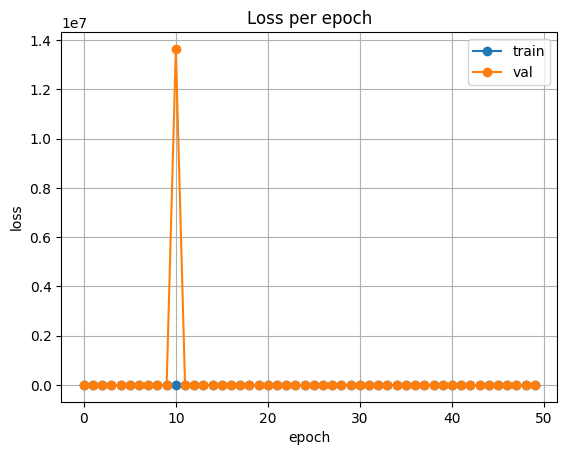

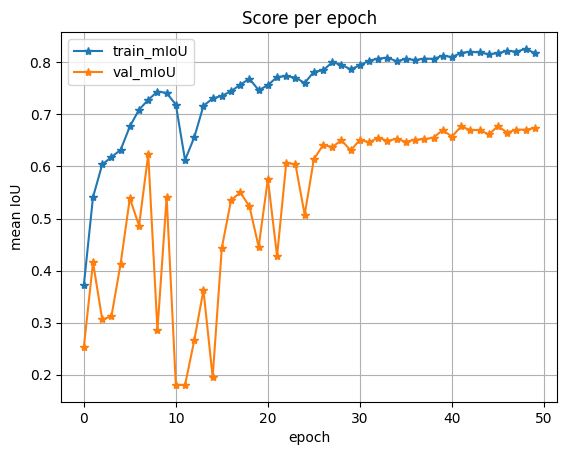

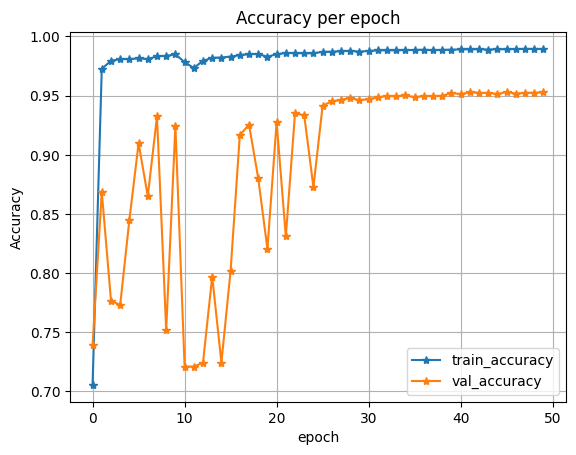

In [34]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation
## Result

In [35]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    
    
    with torch.no_grad():
        
        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)
        
        output = model(image)
        a,b,c,d = output.shape
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3,1)

In [36]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [37]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

In [38]:
image, mask = next(iter(val_dataloader))
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

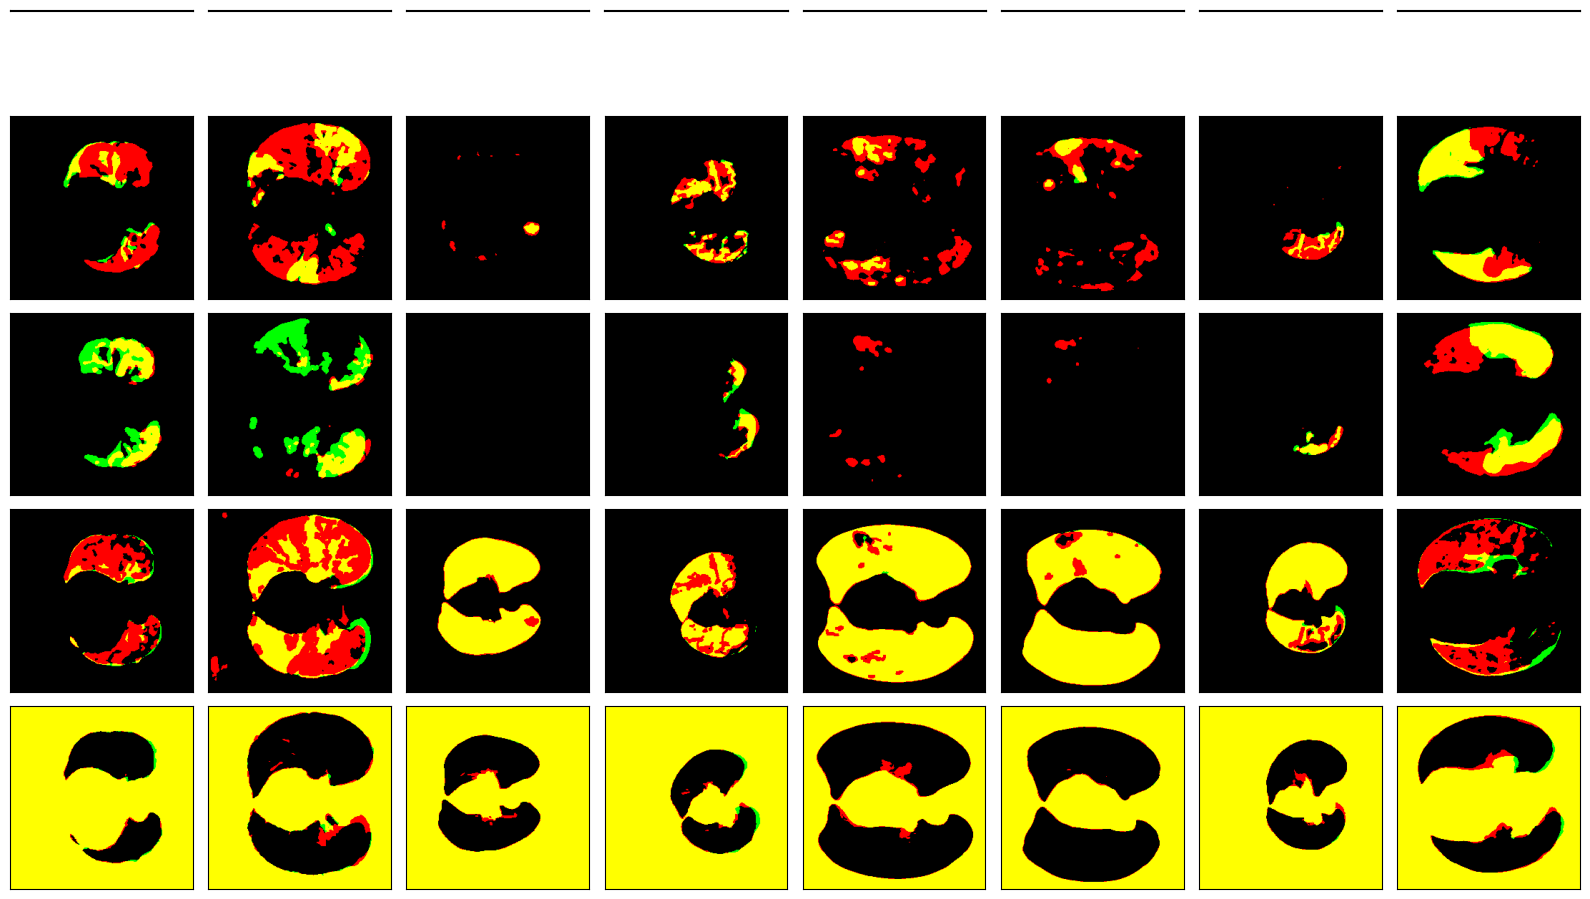

In [39]:

visualize(image.cpu(), semantic_map, pred_batch=output.cpu())
#Si estamos con gpu es necesario cambiarlos a cpu porque numpy solo trabaja con cpu :(
# yellow is TP, red is FP, green is FN

In [40]:
def miou_score(model, test_set):
    score_iou = []
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [41]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.6738557741825943]

In [42]:
del train_images
del train_masks

## Test preds:

In [43]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.eval()
    
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        output = model(torch.unsqueeze(image,1))
        output = nn.Softmax(dim=1)(output)
    return output.permute(0, 2, 3,1)

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


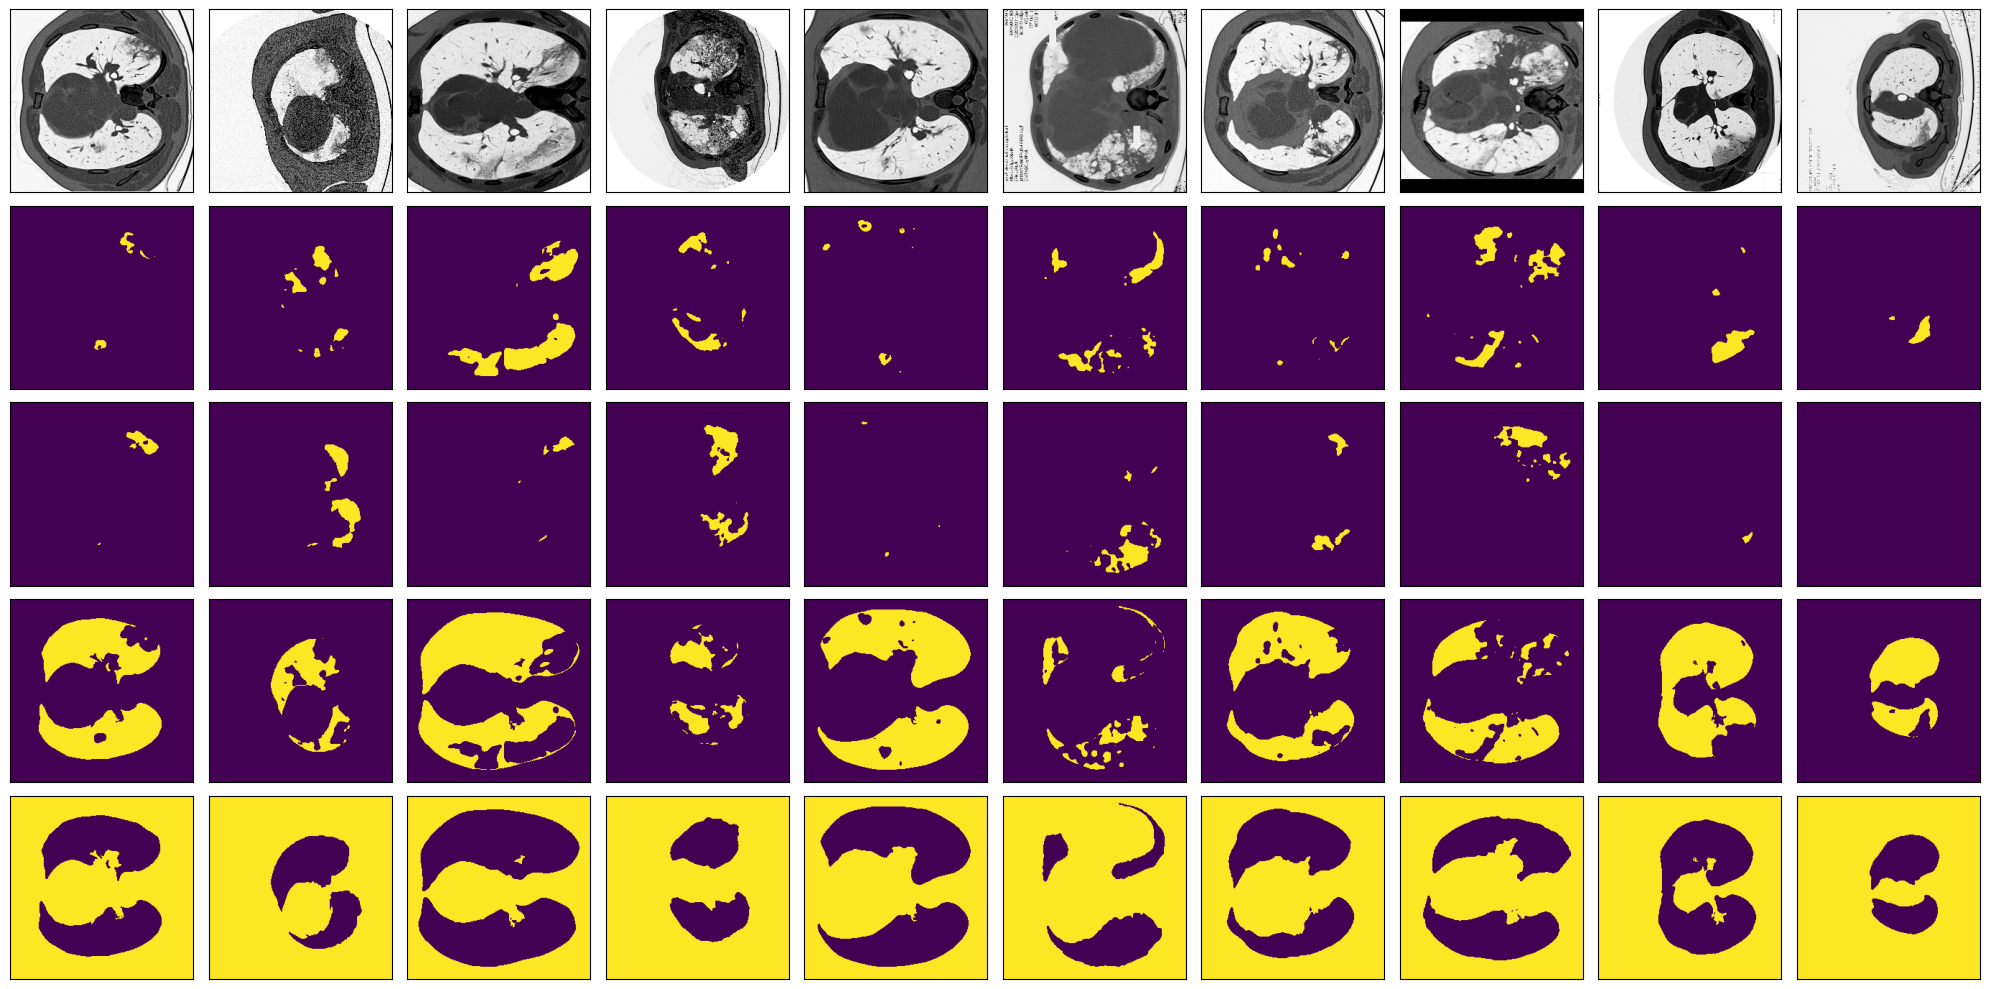

In [44]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
output = np.zeros((10,256,256,4))
for i in range(10):   
    output[i] = test_predict(model, image_batch[i]).cpu()
print(output.shape)
test_masks_prediction = output > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

## Resize prediction to original size:

In [45]:
import scipy
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [46]:
import pandas as pd

pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())), 
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')

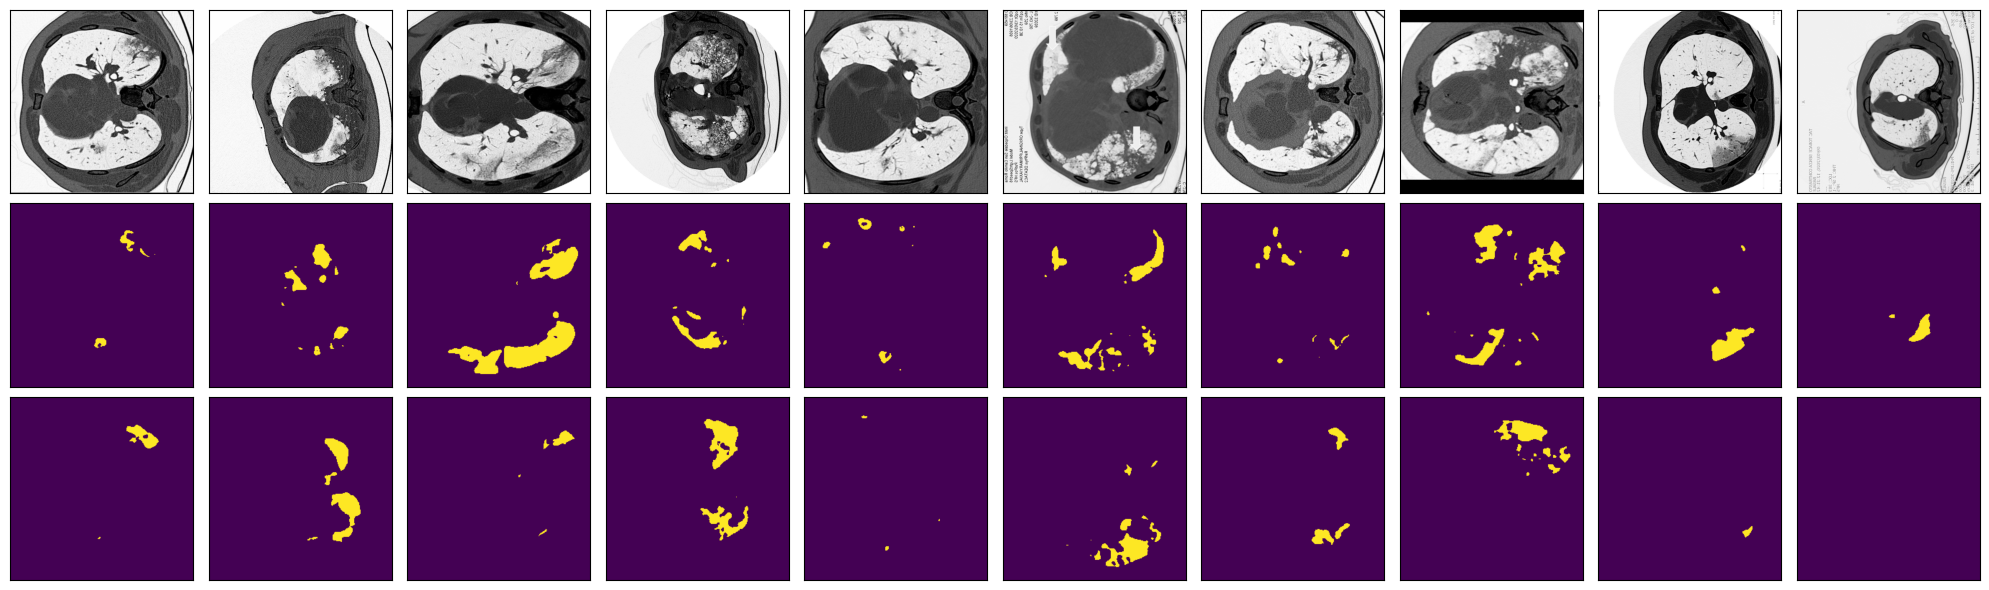

In [48]:
visualize(test_images_medseg, test_masks_prediction_original_size, num_samples=len(test_images_medseg), hot_encode=True)

# Referencias

[1] https://aws.amazon.com/what-is/data-augmentation/

[2] https://www.kaggle.com/code/maedemaftouni/pytorch-baseline-for-semantic-segmentation/notebook

[3] https://encord.com/glossary/iou-definition/

[4] https://www.sciencedirect.com/topics/computer-science/pixel-accuracy

[5] Zhou Z, Siddiquee MMR, Tajbakhsh N, Liang J. UNet++: A Nested U-Net Architecture for Medical Image Segmentation. Deep Learn Med Image Anal Multimodal Learn Clin Decis Support (2018). 2018 Sep;11045:3-11. doi: 10.1007/978-3-030-00889-5_1. Epub 2018 Sep 20. PMID: 32613207; PMCID: PMC7329239.
https://pmc.ncbi.nlm.nih.gov/articles/PMC7329239/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=38a5b3a5-33a5-4f4e-ae6c-f17d01ca6c6a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>